In [420]:
# Tensorflow imports
from tensorflow.test import is_gpu_available
from tensorflow.keras.models import Sequential, load_model, model_from_json, Model
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers

# Sklearn imports
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Mongo
from pymongo import MongoClient

# Pandas and numpy
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(18, 4)})

# Other
from scipy.ndimage.filters import gaussian_filter1d
from IPython.display import Image
from datetime import datetime, timedelta
from math import sqrt

import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3" 

In [403]:
is_gpu_available()

True

### Connect to mongo database

In [2]:
# Mongo client
client = MongoClient('mongodb://165.22.199.122:27017')
db = client.processed
data = db.external

In [323]:
# Load the data
df= (pd.DataFrame(list(data.find()))
    .drop('_id', 1)
    .set_index('timestamp')
    .sort_index()
    .dropna())

df.head()

,n_tweets,price,sentiment
timestamp,,,
2017-08-02 05:00:00,509.0,2735.27,0.068275
2017-08-02 06:00:00,892.0,2732.12,0.076942
2017-08-02 07:00:00,830.0,2731.96,0.080092
2017-08-02 08:00:00,819.0,2710.21,0.082844
2017-08-02 09:00:00,1196.0,2719.31,0.087544


In [324]:
# pipeline = [
#     {"$unwind": "$window"},
#     {'$addFields': {'window': '$window.start'}}
# ]

### Function to create timeline plot

In [325]:
def plot_timeline(first_feature, second_feature):
    sns.set_style("dark")
    
    fig, ax1 = plt.subplots()

    ax1.plot(df['2019-01-02 08:00:00':][first_feature], label=first_feature)
    ax1.legend(loc='upper left')
    ax2 = ax1.twinx()
    ax2.plot(df['2019-01-02 08:00:00':][second_feature], color='orange', label=second_feature)
    ax2.legend(loc='upper right')

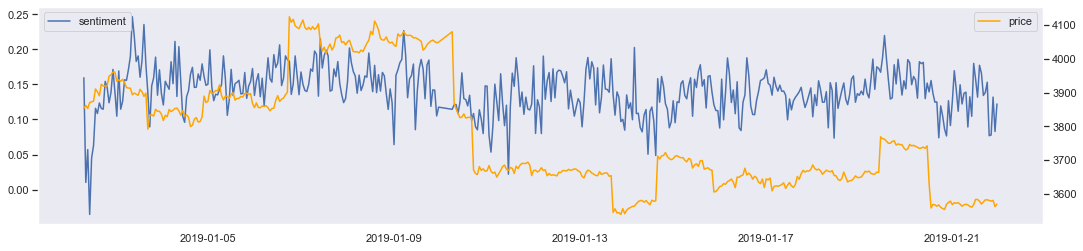

In [326]:
plot_timeline('sentiment', 'price')

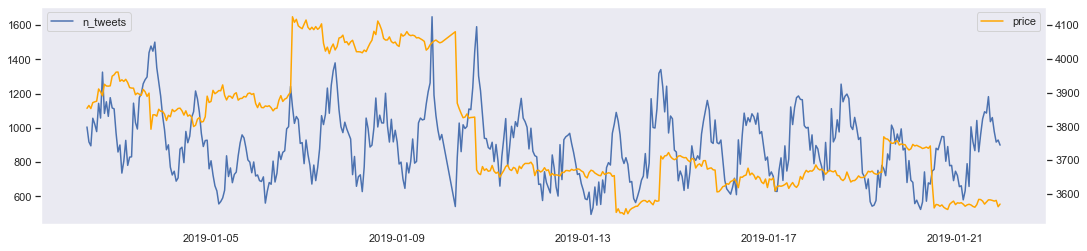

In [327]:
plot_timeline('n_tweets', 'price')

### Prepare training data

In [328]:
n_steps = 12
n_features = 3
train_size = int(.75 * len(df))

In [341]:
def split_sequence(sequence, n_steps, y_col=0):
    X, y = [], []
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
        
    return np.array(X)

#### Train test split

In [342]:
prices = df['price'].values
prices_train, prices_test = prices[:train_size], prices[train_size:]

In [343]:
sentiment = df['sentiment'].values
sentiment_train, sentiment_test = sentiment[:train_size], sentiment[train_size:]

In [344]:
n_tweets = df['n_tweets'].values
n_tweets_train, n_tweets_test = n_tweets[:train_size], n_tweets[train_size:]

In [345]:
train = np.stack([prices_train, sentiment_train, n_tweets_train], axis=1)
test = np.stack([prices_test, sentiment_test, n_tweets_test], axis=1)

#### Scale the data

In [346]:
scaler = Normalizer()

In [347]:
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

#### Generate sequences

In [348]:
X_train = split_sequence(train_scaled, n_steps)

In [349]:
X_test = split_sequence(test_scaled, n_steps)

In [369]:
y_test = df.iloc[-len(X_test):]['price'].values
y_train = df.iloc[n_steps:len(X_train)+n_steps]['price'].values

In [370]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((9241, 12, 3), (9241,), (3073, 12, 3), (3073,))

In [375]:
y_train

array([2714.69, 2705.97, 2710.11, ..., 6444.22, 6457.58, 6431.09])

### Build the keras model

In [414]:
def build_bidirectional_model(X, y):
    model = Sequential()
    model.add(Bidirectional(LSTM(256, activation='relu'), input_shape=(n_steps, n_features)))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(.6))
    model.add(Dense(1))
    model.compile(optimizer='rmsprop', loss='mse')
    
    return model

In [416]:
# Create the model
bidirectional_model = build_bidirectional_model(X_train, y_train)

# Fit the model
bidirectional_model.fit(X_train, y_train, validation_split=.2, epochs=50, batch_size=256);

Train on 7392 samples, validate on 1849 samples
Epoch 1/50
7392/7392 [==============================] - 3s 432us/sample - loss: 44444661.4545 - val_loss: 1444033.4909
Epoch 2/50
7392/7392 [==============================] - 1s 181us/sample - loss: 24914994.3377 - val_loss: 3099462.6198
Epoch 3/50
7392/7392 [==============================] - 1s 184us/sample - loss: 24791609.3506 - val_loss: 13665172.7555
Epoch 4/50
7392/7392 [==============================] - 1s 184us/sample - loss: 22855397.3506 - val_loss: 7591161.9719
Epoch 5/50
7392/7392 [==============================] - 1s 195us/sample - loss: 22767324.5195 - val_loss: 2944004.0412
Epoch 6/50
7392/7392 [==============================] - 1s 184us/sample - loss: 21593795.3853 - val_loss: 3114827.8910
Epoch 7/50
7392/7392 [==============================] - 1s 187us/sample - loss: 22099789.9048 - val_loss: 3685770.4360
Epoch 8/50
7392/7392 [==============================] - 1s 189us/sample - loss: 20611480.2078 - val_loss: 3309199.5180

In [425]:
# Predict using the test data
y_hat = bidirectional_model.predict(X_test)

In [431]:
# Root mean squared error
'RMSE: ${:.2f}'.format(sqrt(mean_squared_error(y_test, y_hat)))

'RMSE: $2317.44'

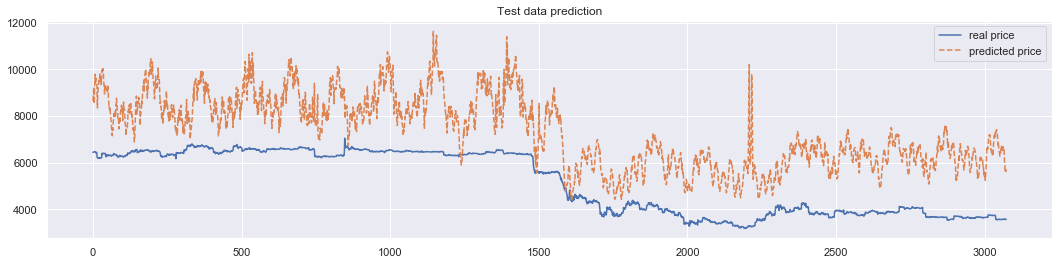

In [424]:
plt.plot(y_test, label='real price')
plt.plot(y_hat, linestyle='dashed', label='predicted price')
plt.title('Test data prediction')
plt.legend();

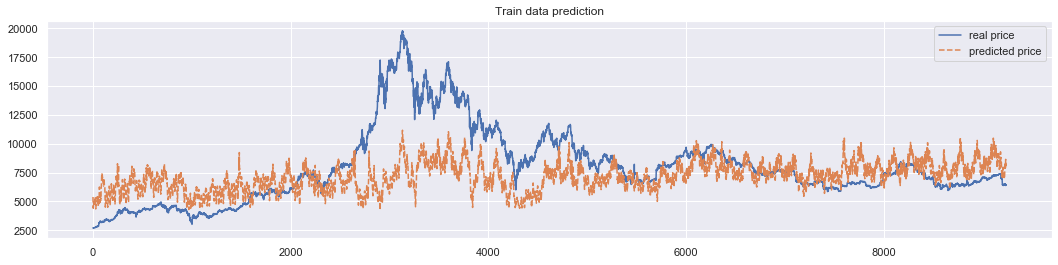

In [422]:
# Predict using the train data
y_hat_train = bidirectional_model.predict(X_train)
plt.plot(y_train, label='real price')
plt.plot(y_hat_train, linestyle='dashed', label='predicted price')
plt.title('Train data prediction')
plt.legend();